# One milion songs

In this notebook, we will work with a dataset cotaining information on one milion songs released over the past 50 years (https://labrosa.ee.columbia.edu/millionsong/ ). In particular, we will build a heatmap to see if we can identify what tempi has been popular over the years.

In [3]:
data = spark.read.csv("gs://big-data-course-datasets/one-million-songs/one-million-songs.csv",  \
             header=True).rdd.cache()

In [4]:
data.toDF().show()

+--------------------+--------------------+----+---------+--------+---+-------+
|         artist_name|          track_name|year| duration|loudness|key|  tempo|
+--------------------+--------------------+----+---------+--------+---+-------+
|         Baka Beyond|Journey (Album Ve...|1995|368.14322| -11.482|  9|139.092|
|      The Fleetwoods|      Ten Times Blue|1993|175.59465| -15.193|  5|  87.65|
|        Joe Satriani|        It's So Good|2006|254.85016|  -4.707|  7| 87.875|
|                 BIZ|              Ghosts|   0|233.40363|  -5.972|  9| 97.997|
|        Memphis Slim|Baby Please Come ...|   0|110.62812|   -20.1|  5|200.962|
|        LANDA DANIEL|A KDO TEDA VODDEL...|   0|162.21995| -13.007|  9| 97.912|
|  Middle Of The Road|       Bonjour ca va|1999|188.49914|  -7.202|  2|128.033|
|           Nightwish|Over The Hills An...|2001|300.38159|  -5.401|  4|135.824|
|          Nickodemus|  Endangered Species|2008|276.53179|  -8.107|  3| 63.344|
|              Tyrese|       Gotta Get Y

Creating a heatmap from this data involves almost the same map and reduce steps that we saw when doing word count. The difference is that the key will not be individual words in this case. In stead, we are interested in counting how many songs of a particular year there is with a particular tempo. This means that we will have a composite key consisting of year and tempo.

In [17]:
# There is some noise and some missing data in the dataset, 
# so we will only look at songs with a tempo in the range 88 to 150
# and from years in the range 1960 to 2010
min_tempo = 88
max_tempo = 150
min_year = 1964
max_year = 2010

resolution_tempo = max_tempo - min_tempo
resolution_year = max_year - min_year

# When we do the map and reduce operations the key will be (year, tempo)
counts=data.map(lambda row: ((int(row['year']), int(float(row['tempo']))), 1)) \
  .reduceByKey(lambda x,y: x+y)  \
  .filter(lambda x: x[0][0]>=min_year and x[0][0]<max_year)  \
  .filter(lambda x: x[0][1]>=min_tempo and x[0][1]<max_tempo)


In [25]:
counts.take(10)

[((1995, 139), 118),
 ((2001, 135), 267),
 ((2004, 92), 325),
 ((2003, 93), 324),
 ((1972, 136), 26),
 ((2006, 108), 250),
 ((1998, 108), 139),
 ((1991, 105), 106),
 ((1995, 93), 151),
 ((2008, 88), 318)]

We now have the data we want, but the format is not ideal for plotting a heatmap, so some further manipulation is needed. We have also reduced the size of the data enough to move from the realm of big data to the realm of small data. The data in **counts** is of size (max_tempo-min_tempo)x(max_year-min_year). This is small enough for us to **collect()** and do the rest of the manipulation outside of Spark, but since we want to learn some more Spark let us not collect quite yet.

To plot the heat map we would ideally like to have a DataFrame with each row representing a tempo and each column representing a year:

| Tempo | 1964 | 1965 | 1966 | 1967 | 1968 | 1969 |  ... |
|-------|------|------|------|------|------|------|------|
| 140   | 33   |   41 |  39  |   44 |  32  |   45 |  ... |
| 139   | 54   |   51 |  62  |   34 |  36  |   62 |  ... |
| 138   | 63   |   45 |  57  |   55 |  62  |   51 |  ... |
| ...   |  ... |  ... | ...  |  ... |  ... |  ... |  ... |

Let us see what Spark operations that can give us the data with this structure. In the following cells we build the structure one operation at a time. First let us get turn the rows into dictionaries, so that we know what we are dealing with:

In [26]:
counts.map(lambda x: {"year": x[0][0], "tempo": x[0][1], "count": x[1]}).take(10)

[{'year': 1995, 'tempo': 139, 'count': 118},
 {'year': 2001, 'tempo': 135, 'count': 267},
 {'year': 2004, 'tempo': 92, 'count': 325},
 {'year': 2003, 'tempo': 93, 'count': 324},
 {'year': 1972, 'tempo': 136, 'count': 26},
 {'year': 2006, 'tempo': 108, 'count': 250},
 {'year': 1998, 'tempo': 108, 'count': 139},
 {'year': 1991, 'tempo': 105, 'count': 106},
 {'year': 1995, 'tempo': 93, 'count': 151},
 {'year': 2008, 'tempo': 88, 'count': 318}]

We will need to reduce the number of rows and group them by tempo in order to get to the wider table. This can be done in Spark by a **reduceByKey()** operation, so to prepare for this we do another map function so that the rows now are tuples of tempo and a list containing one element which is a tuple of year and count.

In [38]:
counts.map(lambda x: {"year": x[0][0], "tempo": x[0][1], "count": x[1]}) \
    .map(lambda x: (x["tempo"], [(x["year"], x["count"])])) \
    .take(10)

[(139, [(1995, 118)]),
 (135, [(2001, 267)]),
 (92, [(2004, 325)]),
 (93, [(2003, 324)]),
 (136, [(1972, 26)]),
 (108, [(2006, 250)]),
 (108, [(1998, 139)]),
 (105, [(1991, 106)]),
 (93, [(1995, 151)]),
 (88, [(2008, 318)])]

Similarly to what we have done before we reduce the data with the **reduceByKey()** operation as an addition. What is different in this case is that we are not adding integers, but rather we are adding lists, which in Python means that we are concatenating the lists.

In [39]:
counts.map(lambda x: {"year": x[0][0], "tempo": x[0][1], "count": x[1]}) \
    .map(lambda x: (x["tempo"], [(x["year"], x["count"])])) \
    .reduceByKey(lambda x,y: x+y) \
    .take(10)

[(92,
  [(2004, 325),
   (1994, 149),
   (2008, 342),
   (1992, 101),
   (1996, 172),
   (2000, 212),
   (2006, 399),
   (1968, 21),
   (2002, 263),
   (1980, 24),
   (1972, 23),
   (1966, 15),
   (1978, 21),
   (1976, 28),
   (1988, 54),
   (1982, 25),
   (1998, 168),
   (1986, 35),
   (1984, 28),
   (1990, 57),
   (1970, 28),
   (1974, 17),
   (1964, 7),
   (2007, 395),
   (2003, 339),
   (2009, 280),
   (1999, 219),
   (2001, 248),
   (2005, 379),
   (1969, 32),
   (1983, 29),
   (1997, 185),
   (1995, 154),
   (1993, 136),
   (1979, 32),
   (1977, 15),
   (1987, 61),
   (1991, 81),
   (1989, 70),
   (1967, 23),
   (1985, 29),
   (1973, 23),
   (1971, 25),
   (1981, 25),
   (1975, 19),
   (1965, 18)]),
 (136,
  [(1972, 26),
   (1984, 62),
   (2006, 343),
   (2008, 321),
   (2004, 303),
   (1980, 28),
   (1998, 146),
   (1994, 127),
   (2002, 211),
   (1996, 134),
   (1992, 94),
   (1986, 45),
   (2000, 202),
   (1988, 57),
   (1970, 19),
   (1974, 35),
   (1982, 54),
   (1978, 22),


So, now each row consist of a tuple of tempo and a list of years and counts. This is the data that we need for each row. We just need one more **map()** operation to put the data into a dictionary that we can then collect. We therefore define a little function that does exactly this.

In [51]:
def make_row(tempo, list_of_year_counts):
    row={}
    row["tempo"]=tempo
    for year_count in list_of_year_counts:
        row[str(year_count[0])]=year_count[1]
    return row

counts.map(lambda x: {"year": x[0][0], "tempo": x[0][1], "count": x[1]}) \
    .map(lambda x: (x["tempo"], [(x["year"], x["count"])])) \
    .reduceByKey(lambda x,y: x+y) \
    .map(lambda x: make_row(x[0], x[1])) \
    .take(10)

[{'tempo': 92,
  '2004': 325,
  '1994': 149,
  '2008': 342,
  '1992': 101,
  '1996': 172,
  '2000': 212,
  '2006': 399,
  '1968': 21,
  '2002': 263,
  '1980': 24,
  '1972': 23,
  '1966': 15,
  '1978': 21,
  '1976': 28,
  '1988': 54,
  '1982': 25,
  '1998': 168,
  '1986': 35,
  '1984': 28,
  '1990': 57,
  '1970': 28,
  '1974': 17,
  '1964': 7,
  '2007': 395,
  '2003': 339,
  '2009': 280,
  '1999': 219,
  '2001': 248,
  '2005': 379,
  '1969': 32,
  '1983': 29,
  '1997': 185,
  '1995': 154,
  '1993': 136,
  '1979': 32,
  '1977': 15,
  '1987': 61,
  '1991': 81,
  '1989': 70,
  '1967': 23,
  '1985': 29,
  '1973': 23,
  '1971': 25,
  '1981': 25,
  '1975': 19,
  '1965': 18},
 {'tempo': 136,
  '1972': 26,
  '1984': 62,
  '2006': 343,
  '2008': 321,
  '2004': 303,
  '1980': 28,
  '1998': 146,
  '1994': 127,
  '2002': 211,
  '1996': 134,
  '1992': 94,
  '1986': 45,
  '2000': 202,
  '1988': 57,
  '1970': 19,
  '1974': 35,
  '1982': 54,
  '1978': 22,
  '1990': 46,
  '1976': 26,
  '1966': 13,
  '19

We now have the data in the structure that we need. This way of doing it consist of a chain of two **map()** operations, one **reduceByKey()** operation and finally a **map()** operation again. Let us collect this data by turning it into a Pandas DataFrame that can be plottet.

In [56]:
heatmap_dataframe=counts.map(lambda x: {"year": x[0][0], "tempo": x[0][1], "count": x[1]}) \
    .map(lambda x: (x["tempo"], [(x["year"], x["count"])])) \
    .reduceByKey(lambda x,y: x+y) \
    .map(lambda x: make_row(x[0], x[1])) \
    .toDF() \
    .toPandas()

We are now ready to plot the heatmap.

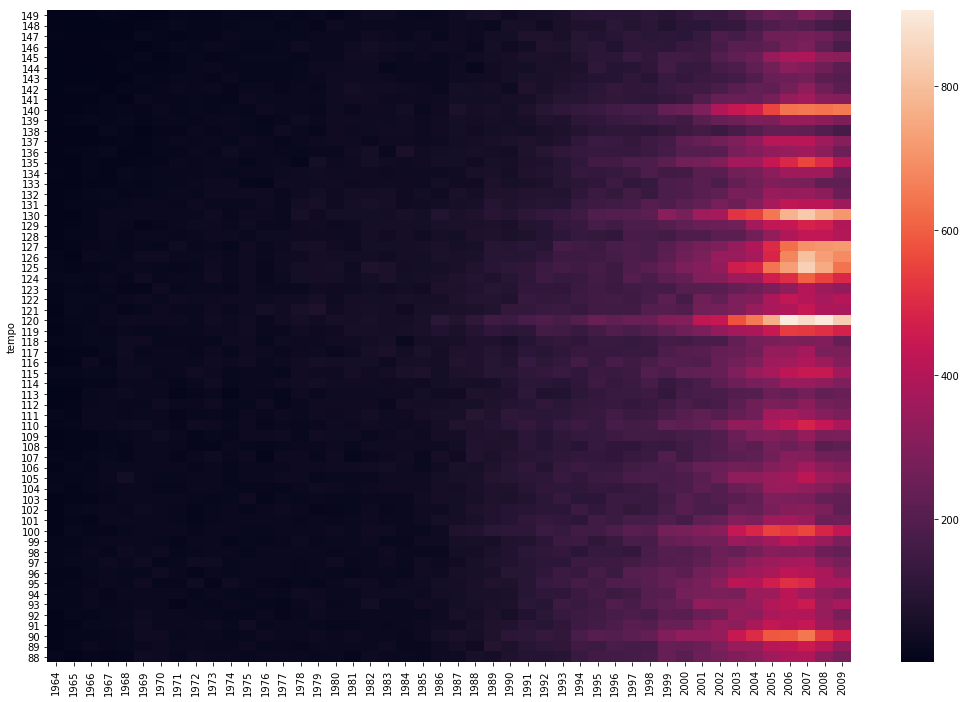

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(18, 12))
ax = sns.heatmap(heatmap_dataframe.set_index("tempo").sort_values(by="tempo", ascending=False))


------------------

# Assignment

The heatmap looks OK, but there is a problem. It is clear that the dataset contains much more recent music than songs from the 1960's and 1970's, so that area is completely dark on the heatmap. This can be solved by *normalizing* the data by year. In stead of basing the heatmap on counts of a particular year and tempo, then base it on the fraction of that years songs which are at that tempo. In practice we want a table of the counts divided by the count of all the songs of that year.

See if you can make a better heatmap by normalizing the data by year.

We start by finding the song counts by year:

In [77]:
songs_per_year = dict(counts.map(lambda x: (x[0][0], x[1])) \
    .reduceByKey(lambda x,y: x+y) \
    .collect())

That allows us to rewrite the function constructing the rows:

In [78]:
def make_row_normalized(tempo, list_of_year_counts):
    row={}
    row["tempo"]=tempo
    for year_count in list_of_year_counts:
        row[str(year_count[0])] = 1.0 * year_count[1] / songs_per_year[year_count[0]]
    return row

/usr/lib/spark/python/pyspark/sql/session.py:360: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


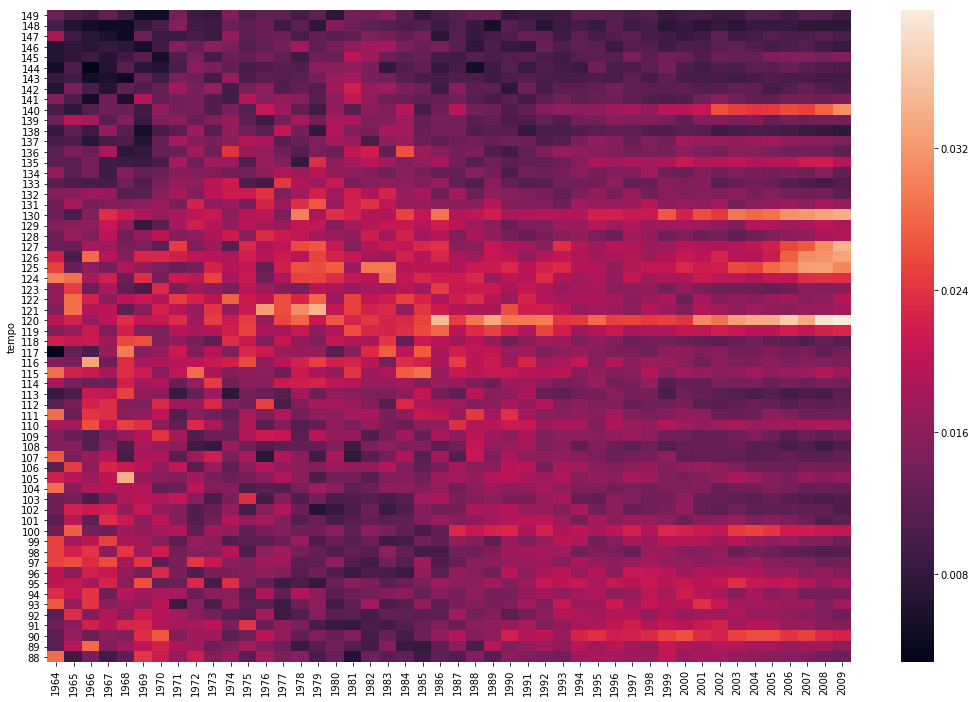

In [80]:
heatmap_dataframe=counts.map(lambda x: {"year": x[0][0], "tempo": x[0][1], "count": x[1]}) \
    .map(lambda x: (x["tempo"], [(x["year"], x["count"])])) \
    .reduceByKey(lambda x,y: x+y) \
    .map(lambda x: make_row_normalized(x[0], x[1])) \
    .toDF() \
    .toPandas()

plt.figure(figsize=(18, 12))
ax = sns.heatmap(heatmap_dataframe.set_index("tempo").sort_values(by="tempo", ascending=False))

The new heatmap reveals some changes in recording technology that were introduced around 1990.